## Failure ratio of master jobs
Jobs initiated in an interval of one hour over the last 14 days

In [1]:
%matplotlib inline
import sys
import os
import datetime, calendar
import azure.cosmos.cosmos_client as cosmos_client
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
client = cosmos_client.CosmosClient(url_connection=os.environ['endpoint'], auth={'masterKey': os.environ['masterKey']})

database_link = 'dbs/' + os.environ['databaseId']
collection_link = database_link + '/colls/{}'.format(os.environ['containerId'])

In [3]:
from datetime import datetime, timedelta
now = datetime.now()
one_hour = timedelta(hours=1)
    
# Number of days we want to go back in
hours_in_past = 24 * 14
    
reversed_last_hours = list(
    map(
        lambda i: (now - (i * one_hour)).isoformat(),
        range(hours_in_past + 1)
    )
)

last_hours = reversed_last_hours[::-1]

first_hour, *tail_hours = last_hours

query = {
    "query": """
     SELECT c.job_name, c.build_id, c.current_build_current_result, c.stage_timestamp, c._ts
     FROM c
     WHERE c.current_build_scheduled_time > '{0}Z'
         and c.branch_name = 'master'
    """.format(first_hour)
}

query_results = list(client.QueryItems(collection_link, query))

df = pd.DataFrame(query_results)

In [4]:
def hour_builds(hour_df):
    return pd.DataFrame(
        hour_df
            .sort_values(by='stage_timestamp')
            .drop_duplicates('job_name', keep='last')
    )

def hour_df(frame, hour_number):
    return frame[
        (frame['stage_timestamp'] > last_hours[hour_number])
        & (frame['stage_timestamp'] < last_hours[hour_number + 1])
    ]

builds = list(
    map(
        lambda hour_number: hour_builds(hour_df(df, hour_number)),
        list(range(len(last_hours) - 1))
    )
)

In [5]:
def status_ratio(status, total):
    return 100 if total == 0 else round(status/total * 100)

def hour_stats(i, current_build):
    total_rows = len(current_build)
    
    successes = len(current_build.loc[df['current_build_current_result'] == 'SUCCESS'])
    failures = len(current_build.loc[df['current_build_current_result'] == 'FAILURE'])
    aborted = len(current_build.loc[df['current_build_current_result'] == 'ABORTED'])
    unknows = total_rows - successes - failures - aborted
    
    total = successes + failures + aborted
    
    return ({
        "successes": successes,
        "failures": failures,
        "aborted": aborted,
        "unknows": unknows,
        "success_ratio": status_ratio(successes, total),
        "failure_ratio": status_ratio(failures, total),
        "aborted_ratio": status_ratio(aborted, total),
        "unknows_ratio": status_ratio(unknows, total),
        "date": last_hours[i],
    })

all_hours_stats = [hour_stats(i,x) for i,x in enumerate(builds)]

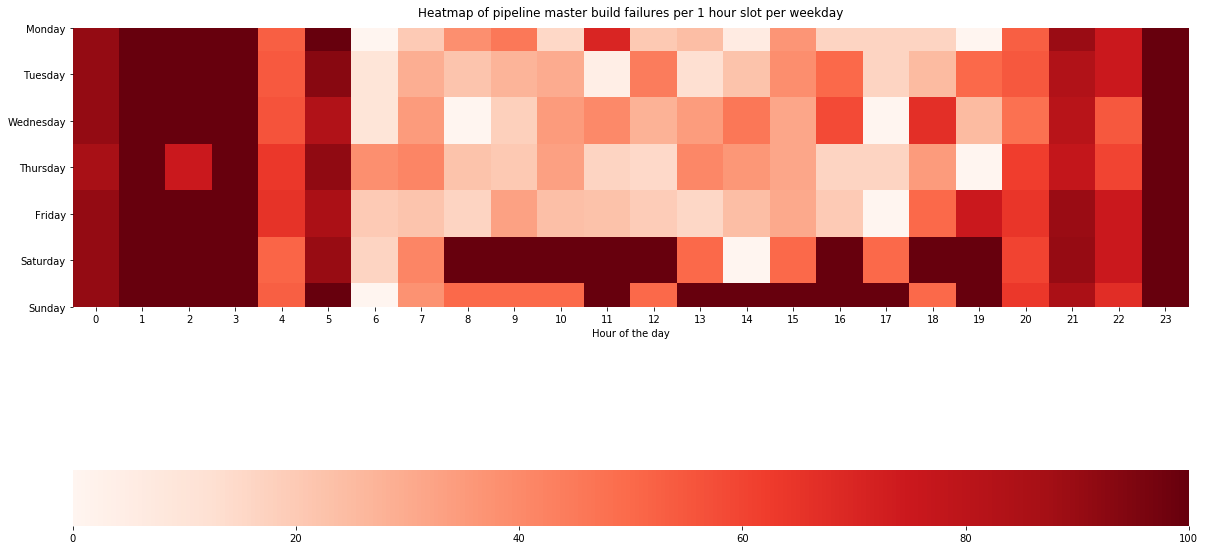

In [77]:
import seaborn as sns
import numpy as np

stuff_df = pd.DataFrame.from_dict(all_hours_stats)
stuff_df['hour'] = pd.to_datetime(stuff_df['date'], errors='coerce', infer_datetime_format=True).dt.hour
stuff_df['day'] = pd.to_datetime(stuff_df['date'], errors='coerce', infer_datetime_format=True).dt.weekday_name

pivot_stuff_df = pd.pivot_table(
    stuff_df,
    values='failure_ratio',
    columns='hour',
    index=['day'],
    aggfunc=np.mean)

pivot_stuff_df.unstack(level=0)

# Make the days appear in the week order
pivot_stuff_df = pivot_stuff_df.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=0)

f, ax = plt.subplots(figsize=(20, 20))
ax.axes.set_title("Heatmap of pipeline master build failures per 1 hour slot per weekday", y=1.02)
ax = sns.heatmap(pivot_stuff_df,
                 fmt="d",
                 linewidths=0, 
                 ax=ax,
                 square=True,
                 cmap="Reds",
                 cbar_kws={"orientation": "horizontal"}
                )
ax.set(xlabel='Hour of the day', ylabel=None);
